In [1]:
import os
import cv2
import numpy as np
import yaml
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def get_yaml_files(path):
    yaml_list = []
    for main_dir in os.listdir(path):
        current_dir = os.path.join(path, main_dir)
        for sub_dir in os.listdir(current_dir):
            if ".yaml" in sub_dir:
                yaml_path = os.path.join(current_dir, sub_dir)
                with open(yaml_path, "r") as stream:
                    try:
                        yaml_content = yaml.load(stream)
                        yaml_list.append((yaml_path, yaml_content))
                    except yaml.YAMLError as exc:
                        print(exc)
    return yaml_list
                    
def get_data(yaml_list, act_topic="/engine_wrapper/output/default"):
    data_list = []
    for yaml_path, yaml_file in yaml_list:
        for snapshot in yaml_file:
            timestamp = snapshot["timestamp"]
            steering =  snapshot["action_messages"][act_topic]["drive"]["steering_angle"]
            img_path_list = snapshot["camera_messages"]
            for img_path in img_path_list:
                img_path = os.path.dirname(yaml_path) + img_path
                if os.path.isfile(img_path):
                    img = cv2.imread(img_path)
                    data_list.append([timestamp, img, steering])
    return data_list

def get_x_y_from_data(data):
    x = []
    y = []
    
    for _, img, steer in data:
        x.append(img)
        y.append(steer)
        
    return np.asarray(x), np.asarray(y)

def process_imgs(imgs):
    result = []
    for img in imgs:
        img_shape = img.shape
        img = img[img_shape[0]//3:img_shape[0], 0:img_shape[1]]  # cropping
        img = cv2.resize(img, (0,0), fx=0.25, fy=0.25)  # resizing
        img = img / 255.0  # normalization
        result.append(img)
#         cv2.imshow("window", img)
#         cv2.waitKey(33)
#     cv2.destroyAllWindows()
    return np.array(result)

def slideshow(imgs):
    for img in imgs:
        cv2.imshow("window", img)
        k = cv2.waitKey(33)
        
        if k == 27:  # esc
            break
        
    cv2.destroyAllWindows()

# Allgemeine Werte wie Pfade und Epochen, usw.

In [3]:
sequence_size = 30
batch_size = 1
epochs = 5

data_path = os.path.join(os.getcwd(), "data")

train_path = os.path.join(data_path, "train")
train_aug_path = os.path.join(data_path, "train_aug")

eval_path  = os.path.join(data_path, "eval")
eval_aug_path  = os.path.join(data_path, "eval_aug")

test_path  = os.path.join(data_path, "test")
test_aug_path  = os.path.join(data_path, "test_aug")

log_path = os.path.join(os.getcwd(), "logs")
model_path = os.path.join(os.getcwd(), "models")

lstm_model_path = os.path.join(model_path, "lstm.h5")
gru_model_path = os.path.join(model_path, "gru.h5")
cnn_model_path = os.path.join(model_path, "cnn.h5")

small_model_path = os.path.join(model_path, "small.h5")
nvidia_model_path = os.path.join(model_path, "nvidia.h5")

# Initialisiere Data-Generatoren

In [4]:
from codebase.RNN import MyKerasSequence
import time

t0 = time.time()
train_gen = MyKerasSequence(batch_size, sequence_size, train_path)
print("TRAIN_GEN INIT TIME: {}sec".format(time.time() - t0))

t0 = time.time()
eval_gen = MyKerasSequence(batch_size, sequence_size, eval_path)
print("EVAL_GEN INIT TIME: {}sec".format(time.time() - t0))

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


TRAIN_GEN INIT TIME: 120.53734064102173sec
EVAL_GEN INIT TIME: 37.894927978515625sec


In [5]:
# t0 = time.time()
# train_aug_gen = MyKerasSequence(batch_size, sequence_size, train_aug_path)
# print("TRAIN_AUG_GEN INIT TIME: {}sec".format(time.time() - t0))

# t0 = time.time()
# eval_aug_gen = MyKerasSequence(batch_size, sequence_size, eval_aug_path)
# print("EVAL_AUG_GEN INIT TIME: {}sec".format(time.time() - t0))

In [6]:
print(len(train_gen.data_list))
print(len(eval_gen.data_list))

52149
16371


# Initialisiere Modell

In [7]:
from keras.models import Model, Sequential, load_model
from keras.layers import InputLayer, Input, Dense, Flatten, Reshape, Dropout, Activation
from keras.layers import LSTM, GRU, CuDNNGRU, TimeDistributed
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import backend as K
import keras as k
import tensorflow as tf

def reset_session():
    K.clear_session()
    tf_config = tf.ConfigProto()
    tf_config.gpu_options.allow_growth = True
    K.tensorflow_backend.set_session(tf.Session(config=tf_config))

In [8]:
# # https://machinelearningmastery.com/cnn-long-short-term-memory-networks/

def gru(input_shape, verbose=True):
    reset_session()
    
    batch_size = input_shape[0]
    sequence_size = None
    img_shape = input_shape[2:]
    
    model = Sequential()
    # model.add(InputLayer(batch_input_shape=(batch_size, sequence_size, img_shape[0], img_shape[1], img_shape[2]), name="input"))
    
    model.add(TimeDistributed(Conv2D(filters=32, kernel_size=(11, 11), padding="same", use_bias=False,
                                     batch_size=batch_size, 
                                     input_shape=(sequence_size, img_shape[0], img_shape[1], img_shape[2])
                              ),
                              name="conv01"))
    
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2)), name="pool01"))
    model.add(TimeDistributed(BatchNormalization(), name="conv_batch_norm01"))
    model.add(TimeDistributed(Activation("relu"), name="conv_relu01"))

    model.add(TimeDistributed(Conv2D(filters=64, kernel_size=(5, 5), padding="same", use_bias=False), name="conv02"))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2)), name="pool02"))
    model.add(TimeDistributed(BatchNormalization(), name="conv_batch_norm02"))
    model.add(TimeDistributed(Activation("relu"), name="conv_relu02"))

    model.add(TimeDistributed(Conv2D(filters=128, kernel_size=(3, 3), padding="same", use_bias=False), name="conv03"))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2)), name="pool03"))
    model.add(TimeDistributed(BatchNormalization(), name="conv_batch_norm03"))
    model.add(TimeDistributed(Activation("relu"), name="conv_relu03"))

    model.add(TimeDistributed(Conv2D(filters= 32, kernel_size=(3, 3), padding="same", use_bias=False), name="conv04"))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2)), name="pool04"))
    model.add(TimeDistributed(BatchNormalization(), name="conv_batch_norm04"))
    model.add(TimeDistributed(Activation("relu"), name="conv_relu04"))

    model.add(TimeDistributed(Flatten(), name="flatten"))

    model.add(TimeDistributed(Dense(32, use_bias=False), name="dense01"))
    model.add(TimeDistributed(BatchNormalization(), name="dense_batch_norm01"))
    model.add(TimeDistributed(Activation("tanh"), name="dense_tanh01"))
    model.add(TimeDistributed(Dropout(0.5), name="dense_dropout01"))

    model.add(GRU(32, return_sequences=True, stateful=True, name="gru01"))

    model.add(TimeDistributed(Dense(1, activation='tanh'), name="output"))
    # ARCHITECTURE END
    
    # MODEL BEGIN
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    
    if verbose: 
        print(model.summary())
    # MODEL END
    
    print("RETRUN GRU")
    
    return model

def lstm(input_shape, verbose=True):
    reset_session()

    # ARCHITECTURE BEGIN LSTM02.5
    model = Sequential()
    model.add(TimeDistributed(Conv2D(filters=32, kernel_size=(11, 11), padding="same", use_bias=False), name="conv01", input_shape=input_shape))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2)), name="pool01"))
    model.add(TimeDistributed(BatchNormalization(), name="conv_batch_norm01"))
    model.add(TimeDistributed(Activation("relu"), name="conv_relu01"))

    model.add(TimeDistributed(Conv2D(filters=64, kernel_size=(5, 5), padding="same", use_bias=False), name="conv02"))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2)), name="pool02"))
    model.add(TimeDistributed(BatchNormalization(), name="conv_batch_norm02"))
    model.add(TimeDistributed(Activation("relu"), name="conv_relu02"))

    model.add(TimeDistributed(Conv2D(filters=128, kernel_size=(3, 3), padding="same", use_bias=False), name="conv03"))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2)), name="pool03"))
    model.add(TimeDistributed(BatchNormalization(), name="conv_batch_norm03"))
    model.add(TimeDistributed(Activation("relu"), name="conv_relu03"))

    model.add(TimeDistributed(Conv2D(filters= 32, kernel_size=(3, 3), padding="same", use_bias=False), name="conv04"))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2)), name="pool04"))
    model.add(TimeDistributed(BatchNormalization(), name="conv_batch_norm04"))
    model.add(TimeDistributed(Activation("relu"), name="conv_relu04"))

    model.add(TimeDistributed(Flatten(), name="flatten"))

    model.add(TimeDistributed(Dense(32, use_bias=False), name="dense01"))
    model.add(TimeDistributed(BatchNormalization(), name="dense_batch_norm01"))
    model.add(TimeDistributed(Activation("tanh"), name="dense_tanh01"))
    model.add(TimeDistributed(Dropout(0.5), name="dense_dropout01"))

    model.add(LSTM(32, return_sequences=True, name="lstm01"))

    model.add(TimeDistributed(Dense(1, activation='tanh'), name="output"))
    # ARCHITECTURE END
    
    # MODEL BEGIN
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    
    if verbose: 
        print(model.summary())
    # MODEL END
    
    return model

def lstm_5mio(input_shape, verbose=True):
    reset_session()

    # ARCHITECTURE BEGIN LSTM02.5
    model = Sequential()
    model.add(TimeDistributed(Conv2D(filters=128, kernel_size=(11, 11), padding="same", use_bias=False), name="conv01", input_shape=input_shape))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2)), name="pool01"))
    model.add(TimeDistributed(BatchNormalization(), name="conv_batch_norm01"))
    model.add(TimeDistributed(Activation("relu"), name="conv_relu01"))

    model.add(TimeDistributed(Conv2D(filters=256, kernel_size=(5, 5), padding="same", use_bias=False), name="conv02"))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2)), name="pool02"))
    model.add(TimeDistributed(BatchNormalization(), name="conv_batch_norm02"))
    model.add(TimeDistributed(Activation("relu"), name="conv_relu02"))

    model.add(TimeDistributed(Conv2D(filters=512, kernel_size=(3, 3), padding="same", use_bias=False), name="conv03"))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2)), name="pool03"))
    model.add(TimeDistributed(BatchNormalization(), name="conv_batch_norm03"))
    model.add(TimeDistributed(Activation("relu"), name="conv_relu03"))

    model.add(TimeDistributed(Conv2D(filters= 256, kernel_size=(3, 3), padding="same", use_bias=False), name="conv04"))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2)), name="pool04"))
    model.add(TimeDistributed(BatchNormalization(), name="conv_batch_norm04"))
    model.add(TimeDistributed(Activation("relu"), name="conv_relu04"))

    model.add(TimeDistributed(Flatten(), name="flatten"))

    model.add(TimeDistributed(Dense(256, use_bias=False), name="dense01"))
    model.add(TimeDistributed(BatchNormalization(), name="dense_batch_norm01"))
    model.add(TimeDistributed(Activation("tanh"), name="dense_tanh01"))
    model.add(TimeDistributed(Dropout(0.5), name="dense_dropout01"))

    model.add(LSTM(256, return_sequences=True, name="lstm01"))

    model.add(TimeDistributed(Dense(1, activation='tanh'), name="output"))
    # ARCHITECTURE END
    
    # MODEL BEGIN
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    
    if verbose: 
        print(model.summary())
    # MODEL END
    
    return model

def cnn(input_shape, verbose=True):
    reset_session()
    
    # ARCHITECTURE BEGIN CNN
    model = Sequential()
    model.add(Conv2D(filters= 32, kernel_size=(11, 11), padding="same", use_bias=False, name="conv01", input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), name="pool01"))
    model.add(BatchNormalization(name="batch_norm01"))
    model.add(Activation("relu", name="relu01"))

    model.add(Conv2D(filters=64, kernel_size=(5, 5), padding="same", use_bias=False, name="conv02"))
    model.add(MaxPooling2D(pool_size=(2, 2), name="pool02"))
    model.add(BatchNormalization(name="batch_norm02"))
    model.add(Activation("relu", name="relu02"))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", use_bias=False, name="conv03"))
    model.add(MaxPooling2D(pool_size=(2, 2), name="pool03"))
    model.add(BatchNormalization(name="batch_norm03"))
    model.add(Activation("relu", name="relu03"))

    model.add(Conv2D(filters= 32, kernel_size=(3, 3), padding="same", use_bias=False, name="conv04"))
    model.add(MaxPooling2D(pool_size=(2, 2), name="pool04"))
    model.add(BatchNormalization(name="batch_norm04"))
    model.add(Activation("relu", name="relu04"))

    model.add(Flatten(name="flatten"))

    model.add(Dense(32, use_bias=False, name="dense01"))
    model.add(BatchNormalization(name="dense_batch_norm01"))
    model.add(Activation("tanh", name="dense_tanh01"))
    model.add(Dropout(0.5, name="dense_dropout01"))

    model.add(Dense(32, use_bias=False, name="dense02"))
    model.add(BatchNormalization(name="dense_batch_norm02"))
    model.add(Activation("tanh", name="dense_tanh02"))

    model.add(Dense(1, activation='tanh', name="output"))
    # ARCHITECTURE END

    # MODEL BEGIN
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    
    if verbose: 
        print(model.summary())
    # MODEL END
    
    return model


def small_net(image_shape, verbose=True):
    """
    Self driving approach with a small network

    :param image_shape: TODO
    :type image_shape: Tuple[int, int, int]
    :return: the constructed model instance
    :rtype: keras.models.Model
    """
    reset_session()
    
    model = Sequential()

    model.add(Conv2D(
        filters=8,
        kernel_size=(7, 7),
        activation="relu",
        name="conv1",
        kernel_initializer="glorot_uniform",
        input_shape=image_shape,
        strides=2,
        kernel_regularizer=k.regularizers.l1(0.008)))

    model.add(BatchNormalization())

    model.add(Conv2D(
        filters=16,
        kernel_size=(5, 5),
        activation="relu",
        name="conv2",
        kernel_initializer="glorot_uniform",
        kernel_regularizer=k.regularizers.l1(0.008)))

    model.add(BatchNormalization())

    model.add(Conv2D(
        filters=16,
        kernel_size=(5, 5),
        activation="relu",
        name="conv3",
        kernel_initializer="glorot_uniform",
        kernel_regularizer=k.regularizers.l1(0.002)))

    model.add(Flatten(name="flattened_observation"))

    model.add(Dense(
        units=150, activation="relu", kernel_initializer="glorot_uniform"))

    model.add(Dropout(0.2))

    model.add(Dense(
        units=80, activation="relu", kernel_initializer="glorot_uniform"))

    model.add(Dense(
        units=1, kernel_initializer="glorot_uniform", name="prediction"))

    model.compile(loss="mse", optimizer="adam", metrics=["mae"])
    
    if verbose: 
        print(model.summary())

    return model

def nvidia(image_shape, verbose=True):
    """
    The architecture which has been used in the End to End Learning for
    Self-Driving Cars paper (https://arxiv.org/abs/1604.07316) from nvidia.

    :param image_shape: TODO
    :type image_shape: Tuple[int, int, int]
    :return: the constructed model instance
    :rtype: keras.models.Model
    """
    reset_session()
    
    model = Sequential()

    # Convolution no.1
    model.add(
        Conv2D(filters=24, kernel_size=(5, 5), strides=(2, 2),
               bias_initializer="he_normal", padding="valid",
               input_shape=image_shape, activation="relu"))

    # Convolution no.2
    model.add(
        Conv2D(filters=36, kernel_size=(5, 5), strides=(2, 2),
               bias_initializer="he_normal", padding="valid",
               activation="relu"))

    # Convolution no.3
    model.add(
        Conv2D(filters=48, kernel_size=(5, 5), strides=(1, 1), # stride wurde angepasst auf (1,1) von (2,2) wegen input_shape
               bias_initializer="he_normal", padding="valid",
               activation="relu"))

    # Convolution no.4
    model.add(
        Conv2D(filters=64, kernel_size=(3, 3), bias_initializer="he_normal",
               padding="valid", activation="relu"))

    # Convolution no.5
    model.add(
        Conv2D(filters=64, kernel_size=(3, 3), bias_initializer="he_normal",
               padding="valid", activation="relu"))
    model.add(Flatten())

    # Fully connected no.1
    model.add(Dense(units=1164, bias_initializer="he_normal", activation="relu"))
    model.add(Dropout(0.2))

    # Fully connected no.2
    model.add(Dense(units=100, bias_initializer="he_normal", activation="relu"))
    model.add(Dropout(0.2))

    # Fully connected no.3
    model.add(Dense(units=50, bias_initializer="he_normal", activation="relu"))

    # Fully connected no.4
    model.add(Dense(units=10, bias_initializer="he_normal", activation="tanh"))

    # Fully connected no.5
    model.add(Dense(units=1, bias_initializer="he_normal", activation="tanh",
                    name="prediction"))

    model.compile(loss="mse", optimizer="adam", metrics=["mae"])
    
    if verbose: 
        print(model.summary())

    return model

In [9]:
def gru2(input_shape, verbose=True):
    reset_session()
    
    batch_size = input_shape[0]
    sequence_size = None
    img_shape = input_shape[2:]
    
    
    inputs = Input(batch_shape=(batch_size, sequence_size, img_shape[0], img_shape[1], img_shape[2]), name="input")
    
    conv01 = TimeDistributed(Conv2D(filters=32, kernel_size=(11, 11), padding="same", use_bias=False), name="conv01")(inputs)
    pool01 = TimeDistributed(MaxPooling2D(pool_size=(2, 2)), name="pool01")(conv01)
    norm01 = TimeDistributed(BatchNormalization(), name="conv_batch_norm01")(pool01)
    relu01 = TimeDistributed(Activation("relu"), name="conv_relu01")(norm01)

    conv02 = TimeDistributed(Conv2D(filters=64, kernel_size=(5, 5), padding="same", use_bias=False), name="conv02")(relu01)
    pool02 = TimeDistributed(MaxPooling2D(pool_size=(2, 2)), name="pool02")(conv02)
    norm02 = TimeDistributed(BatchNormalization(), name="conv_batch_norm02")(pool02)
    relu02 = TimeDistributed(Activation("relu"), name="conv_relu02")(norm02)

    conv03 = TimeDistributed(Conv2D(filters=128, kernel_size=(3, 3), padding="same", use_bias=False), name="conv03")(relu02)
    pool03 = TimeDistributed(MaxPooling2D(pool_size=(2, 2)), name="pool03")(conv03)
    norm03 = TimeDistributed(BatchNormalization(), name="conv_batch_norm03")(pool03)
    relu03 = TimeDistributed(Activation("relu"), name="conv_relu03")(norm03)

    conv04 = TimeDistributed(Conv2D(filters= 32, kernel_size=(3, 3), padding="same", use_bias=False), name="conv04")(relu03)
    pool04 = TimeDistributed(MaxPooling2D(pool_size=(2, 2)), name="pool04")(conv04)
    norm04 = TimeDistributed(BatchNormalization(), name="conv_batch_norm04")(pool04)
    relu04 = TimeDistributed(Activation("relu"), name="conv_relu04")(norm04)

    flatten = TimeDistributed(Flatten(), name="flatten")(relu04)

    dense01 = TimeDistributed(Dense(32, use_bias=False), name="dense01")(flatten)
    dense_norm01 = TimeDistributed(BatchNormalization(), name="dense_batch_norm01")(dense01)
    dense_tanh01 = TimeDistributed(Activation("tanh"), name="dense_tanh01")(dense_norm01)
    dense_drop01 = TimeDistributed(Dropout(0.5), name="dense_dropout01")(dense_tanh01)

    gru01 = GRU(32, return_sequences=True, stateful=True, name="gru01")(dense_drop01)

    outputs = TimeDistributed(Dense(1, activation='tanh'), name="output")(gru01)
    # ARCHITECTURE END
    
    # MODEL BEGIN
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    
    if verbose: 
        print(model.summary())
    # MODEL END
    
    return model

In [10]:
def fabian_ket_gru_research_a(image_shape):
        """
        Self driving approach with a gru research project a fabian ket
        net based on https://arxiv.org/abs/1801.06734

        :param image_shape: TODO
        :type image_shape: Tuple[int, int, int]
        :return: the constructed model instance
        :rtype: keras.models.Model
        """

        input_shape = (1, None, image_shape[0], image_shape[1], image_shape[2])

        batch_size = 1
        sequence_size = None

        # ARCHITECTURE BEGIN GRUv2.5
        inputs = Input(batch_shape=(batch_size, sequence_size, image_shape[0], image_shape[1], image_shape[2]), name="input")

        conv01 = TimeDistributed(Conv2D(filters=32, kernel_size=(11, 11), padding="same", use_bias=False), name="conv01")(inputs)
        pool01 = TimeDistributed(MaxPooling2D(pool_size=(2, 2)), name="pool01")(conv01)
        norm01 = TimeDistributed(BatchNormalization(), name="conv_batch_norm01")(pool01)
        relu01 = TimeDistributed(Activation("relu"), name="conv_relu01")(norm01)

        conv02 = TimeDistributed(Conv2D(filters=64, kernel_size=(5, 5), padding="same", use_bias=False), name="conv02")(relu01)
        pool02 = TimeDistributed(MaxPooling2D(pool_size=(2, 2)), name="pool02")(conv02)
        norm02 = TimeDistributed(BatchNormalization(), name="conv_batch_norm02")(pool02)
        relu02 = TimeDistributed(Activation("relu"), name="conv_relu02")(norm02)

        conv03 = TimeDistributed(Conv2D(filters=128, kernel_size=(3, 3), padding="same", use_bias=False), name="conv03")(relu02)
        pool03 = TimeDistributed(MaxPooling2D(pool_size=(2, 2)), name="pool03")(conv03)
        norm03 = TimeDistributed(BatchNormalization(), name="conv_batch_norm03")(pool03)
        relu03 = TimeDistributed(Activation("relu"), name="conv_relu03")(norm03)

        conv04 = TimeDistributed(Conv2D(filters=32, kernel_size=(3, 3), padding="same", use_bias=False), name="conv04")(relu03)
        pool04 = TimeDistributed(MaxPooling2D(pool_size=(2, 2)), name="pool04")(conv04)
        norm04 = TimeDistributed(BatchNormalization(), name="conv_batch_norm04")(pool04)
        relu04 = TimeDistributed(Activation("relu"), name="conv_relu04")(norm04)

        flatten = TimeDistributed(Flatten(), name="flatten")(relu04)

        dens01 = TimeDistributed(Dense(32, use_bias=False), name="dense01")(flatten)
        dens_norm01 = TimeDistributed(BatchNormalization(), name="dense_batch_norm01")(dens01)
        dens_tanh01 = TimeDistributed(Activation("tanh"), name="dense_tanh01")(dens_norm01)
        dens_drop01 = TimeDistributed(Dropout(0.5), name="dense_dropout01")(dens_tanh01)

        gru01, gru01_h = GRU(32, return_sequences=True, return_state=True, stateful=True, name="gru01")(dens_drop01)

        outputs = TimeDistributed(Dense(1, activation='tanh'), name="output")(gru01)
        # ARCHITECTURE END

        model = Model(inputs=inputs, outputs=outputs)
        model.compile(loss='mse', optimizer='adam', metrics=['mse'])

        return model

In [11]:
#   1   2   3   5 10 15 20 30
# 313 231 176 128 85 67 49 40

In [18]:
times = []

# reset_session()
# model = load_model(lstm_model_path)
# model.summary()

batch_size = 1
sequence_size = 30

train_gen.batch_size = batch_size
train_gen.sequence_size = sequence_size
x, y = train_gen[0]
img_shape = x[0][0].shape

input_shape = (batch_size, sequence_size, img_shape[0], img_shape[1], img_shape[2])

model = gru(input_shape, verbose=False)

print("Model created")

x0 = np.asarray([x[0]])

print(x0.shape)

for i in range(100):
    t0 = time.time()
    model.predict(x0)
    model.reset_states()
    times.append(time.time() - t0)

times = np.array(times)

print("MEAN MODEL PRDICTION CALCULATION TIME: {}sec | Hz: {} | Len: {}".format(times.mean(), 1.0 / times.mean(), len(times)))

(48, 96, 3)
Model created
(1, 30, 48, 96, 3)
MEAN MODEL PRDICTION CALCULATION TIME: 0.29246092081069947sec | Hz: 3.4192602458749275 | Len: 100


# Training und Speichern

In [11]:
# # CNN input
# train_gen.sequence_size = 0
# imgs, _ = train_gen[0]
# img_shape = imgs[0].shape
# input_shape = img_shape

batch_size = 1
sequence_size = 30

train_gen.batch_size = batch_size
train_gen.sequence_size = sequence_size

eval_gen.batch_size = batch_size
eval_gen.sequence_size = sequence_size

x, y = train_gen[0]
img_shape = x[0][0].shape

input_shape = (batch_size, sequence_size, img_shape[0], img_shape[1], img_shape[2])

model = fabian_ket_gru_research_a(img_shape)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (1, None, 48, 96, 3)      0         
_________________________________________________________________
conv01 (TimeDistributed)     (1, None, 48, 96, 32)     11616     
_________________________________________________________________
pool01 (TimeDistributed)     (1, None, 24, 48, 32)     0         
_________________________________________________________________
conv_batch_norm01 (TimeDistr (1, None, 24, 48, 32)     128       
_________________________________________________________________
conv_relu01 (TimeDistributed (1, None, 24, 48, 32)     0         
_________________________________________________________________
conv02 (TimeDistributed)     (1, None, 24, 48, 64)     51200     
_________________________________________________________________
pool02 (TimeDistributed)     (1, None, 12, 24, 64)     0         
__________

In [20]:
model.layers[22].states

[<tf.Variable 'gru01_2/Variable:0' shape=(1, 32) dtype=float32_ref>]

In [16]:
from keras.models import load_model
import keras.callbacks as kc


class KerasRestStatesCallback(kc.Callback):
    def __init__(self, model=None):
        self._model = model
        print("Callback model: {}".format(hex(id(self._model))))
        
    # https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L275
    def on_batch_end(self, batch, logs=None):
        pass

    def on_epoch_end(self, epoch, logs=None):
        self._model.reset_states()


reset_session()

batch_size = 1
sequence_size = 120

train_gen.batch_size = batch_size
train_gen.sequence_size = sequence_size

eval_gen.batch_size = batch_size
eval_gen.sequence_size = sequence_size

x, y = train_gen[0]
img_shape = x[0][0].shape

input_shape = (batch_size, sequence_size, img_shape[0], img_shape[1], img_shape[2])

model = fabian_ket_gru_research_a(img_shape)

print("Main model: {}".format(hex(id(model))))

# LOAD MODEL START
# model = load_model(gru_model_path)
# LOAD MODEL END

checkpoint = kc.ModelCheckpoint(gru_model_path, 
                                monitor="val_mean_squared_error",
                                save_best_only=True,
                                mode="min",
                                verbose=1)

reset_state_callback = KerasRestStatesCallback(model=model)


train_gen.grayscale = False
train_gen.flip = False

eval_gen.grayscale = False
eval_gen.flip = True

for i in range(10):
    # TRAINING BEGIN
    history = model.fit_generator(
        generator=train_gen,
        steps_per_epoch=len(train_gen),
        validation_data=eval_gen,
        validation_steps=len(eval_gen),
        epochs=1,
        verbose=1,
        workers=6,
        use_multiprocessing=True,
        callbacks=[checkpoint, reset_state_callback])
    # TRAINING END

# SAVE MODEL START
# model.save(lstm_model_path)
# SAVE MODEL END

Main model: 0x1e471d9bf60
Callback model: 0x1e471d9bf60


In [21]:
print(model.layers[22].states[0][0])

Tensor("strided_slice:0", shape=(32,), dtype=float32)


In [72]:
from keras.models import load_model
import keras.callbacks as kc

# LOAD MODEL START
# model = load_model(lstm_model_path)
# LOAD MODEL END

checkpoint = kc.ModelCheckpoint(lstm_model_path, 
                                monitor="val_mean_absolute_error",
                                save_best_only=True,
                                mode="min",
                                verbose=1)

train_aug_gen.batch_size = 32
train_aug_gen.sequence_size = 5
train_aug_gen.grayscale = False
train_aug_gen.flip = False

eval_aug_gen.batch_size = 32
eval_aug_gen.sequence_size = 5
eval_aug_gen.grayscale = False
eval_aug_gen.flip = False

# TRAINING BEGIN
history = model.fit_generator(
    generator=train_aug_gen,
    steps_per_epoch=len(train_aug_gen),
    validation_data=eval_aug_gen,
    validation_steps=len(eval_aug_gen),
    epochs=50,
    verbose=1,
    workers=6,
    use_multiprocessing=False,
    callbacks=[checkpoint])
# TRAINING END

# SAVE MODEL START
# model.save(lstm_model_path)
# SAVE MODEL END

Epoch 1/50
326/326 [==============================] - 155s 477ms/step - loss: 0.0091 - mean_absolute_error: 0.0653 - val_loss: 0.0113 - val_mean_absolute_error: 0.0711

Epoch 00001: val_mean_absolute_error improved from inf to 0.07107, saving model to D:\Fabians Programme\Studium\Master\2. Semester\Forschungsprojekt A\models\lstm.h5
Epoch 2/50
326/326 [==============================] - 47s 144ms/step - loss: 0.0078 - mean_absolute_error: 0.0607 - val_loss: 0.0121 - val_mean_absolute_error: 0.0732

Epoch 00002: val_mean_absolute_error did not improve from 0.07107
Epoch 3/50
326/326 [==============================] - 47s 146ms/step - loss: 0.0072 - mean_absolute_error: 0.0586 - val_loss: 0.0128 - val_mean_absolute_error: 0.0749

Epoch 00003: val_mean_absolute_error did not improve from 0.07107
Epoch 4/50
326/326 [==============================] - 48s 147ms/step - loss: 0.0067 - mean_absolute_error: 0.0570 - val_loss: 0.0126 - val_mean_absolute_error: 0.0744

Epoch 00004: val_mean_absolut


Epoch 00035: val_mean_absolute_error did not improve from 0.07107
Epoch 36/50
326/326 [==============================] - 49s 150ms/step - loss: 0.0024 - mean_absolute_error: 0.0356 - val_loss: 0.0145 - val_mean_absolute_error: 0.0803

Epoch 00036: val_mean_absolute_error did not improve from 0.07107
Epoch 37/50
326/326 [==============================] - 49s 150ms/step - loss: 0.0024 - mean_absolute_error: 0.0351 - val_loss: 0.0143 - val_mean_absolute_error: 0.0800

Epoch 00037: val_mean_absolute_error did not improve from 0.07107
Epoch 38/50
326/326 [==============================] - 49s 150ms/step - loss: 0.0023 - mean_absolute_error: 0.0347 - val_loss: 0.0153 - val_mean_absolute_error: 0.0832

Epoch 00038: val_mean_absolute_error did not improve from 0.07107
Epoch 39/50
326/326 [==============================] - 48s 148ms/step - loss: 0.0023 - mean_absolute_error: 0.0343 - val_loss: 0.0147 - val_mean_absolute_error: 0.0831

Epoch 00039: val_mean_absolute_error did not improve from 0

# Evaluierung

In [ ]:
# # EVAL BEGIN
# scores = model.evaluate_generator(eval_gen, 
#                                   eval_gen.length, 
#                                   workers=6,
#                                   use_multiprocessing=False,
#                                   verbose=1)

# print("Loss: {} Accuracy: {}".format(scores[0], scores[1]*100))
# # EVAL END

In [45]:
import math
import cv2

TRUE_STEER_COLOR = (0, 255, 0)    # label arrow color
PRED_STEER_COLOR = (255, 255, 0)  # prediction arrow color

MIN_STEER_DEGREES = -90           # max left angle
MAX_STEER_DEGREES = 90            # max right angle

IMAGE_RESIZE_WIDTH = 800

def fmap(value, old_min, old_max, new_min, new_max):
    old_span = old_max - old_min
    new_span = new_max - new_min
    return (value - old_min) * new_span / old_span + new_min

def draw_arrow_on_img(image, angle, color):
    image_width = image.shape[1]
    image_height = image.shape[0]
    image_hor_center = int(image_width / 2)
    arrow_origin = (image_hor_center, image_height)
    arrow_length = image_height / 2

    steer_angle = fmap(angle, -1, 1, MIN_STEER_DEGREES, MAX_STEER_DEGREES)
    steer_angle_rad = math.radians(steer_angle)

    arrow_end = (
        image_hor_center + int(arrow_length * math.sin(steer_angle_rad)),
        image_height - int(arrow_length * math.cos(steer_angle_rad)))

    if color == TRUE_STEER_COLOR:
        cv2.putText(image, "TRUE VALUE", (5, 20), cv2.FONT_HERSHEY_PLAIN, 1, color, 2)
    elif color == PRED_STEER_COLOR:
        cv2.putText(image, "PREDICTION", (5, 40), cv2.FONT_HERSHEY_PLAIN, 1, color, 2)

    return cv2.arrowedLine(image, arrow_origin, arrow_end, color, 4)

def arrowedSlideshow(batch_gen, model=None):
    
    cv2.namedWindow('window', cv2.WINDOW_AUTOSIZE)
    
    width = 0
    height = 0
    
    for x, y in batch_gen:
        prediction = model.predict(x) if (model is not None) else np.zeros_like(y)
        
        if batch_gen.sequence_size == 0:
            for img, pred, truth in zip(x, prediction, y):
                width = img.shape[1]
                height = img.shape[0]

                height = height * IMAGE_RESIZE_WIDTH // width
                width = IMAGE_RESIZE_WIDTH

                img = cv2.resize(img, (width, height))
                img = draw_arrow_on_img(img, truth, TRUE_STEER_COLOR)
                img = draw_arrow_on_img(img, pred, PRED_STEER_COLOR)
                cv2.imshow("window", img)
                k = cv2.waitKey(100)

                if k == 27:  # esc
                    cv2.destroyAllWindows()
                    return

            cv2.imshow("window", (np.ones((height, width))*0.5))
            k = cv2.waitKey(25)
            if k == 27:  # esc
                cv2.destroyAllWindows()
                return
        else:
            for img_seq, pred_seq, truth_seq in zip(x, prediction, y):
                for img, pred, truth in zip(img_seq, pred_seq, truth_seq):
                    width = img.shape[1]
                    height = img.shape[0]
                    
                    height = height * IMAGE_RESIZE_WIDTH // width
                    width = IMAGE_RESIZE_WIDTH

                    img = cv2.resize(img, (width, height))
                    img = draw_arrow_on_img(img, truth, TRUE_STEER_COLOR)
                    img = draw_arrow_on_img(img, pred, PRED_STEER_COLOR)
                    cv2.imshow("window", img)
                    k = cv2.waitKey(100)

                    if k == 27:  # esc
                        cv2.destroyAllWindows()
                        return

            cv2.imshow("window", (np.ones((height, width))*0.5))
            k = cv2.waitKey(25)
            if k == 27:  # esc
                cv2.destroyAllWindows()
                return
                
    cv2.destroyAllWindows()

In [46]:
from codebase.RNN import MyKerasSequence
import time

t0 = time.time()
test_gen = MyKerasSequence(1, 1, test_path)
print("TEST_GEN INIT TIME: {}sec".format(time.time() - t0))
# t0 = time.time()
# test_aug_gen = MyKerasSequence(1, sequence_size, test_aug_path)
# print("TEST_AUG_GEN INIT TIME: {}sec".format(time.time() - t0))

TEST_GEN INIT TIME: 34.52743697166443sec


In [47]:
print(len(test_gen.data_list))

15294


In [9]:
test_gen.batch_size = batch_size
test_gen.sequence_size = sequence_size

print(len(test_gen))

x, y = test_gen[len(test_gen) - 1]

print(x.shape)

96
(1, 94, 48, 96, 3)


In [50]:
from keras.models import load_model

test_gen.batch_size = batch_size
test_gen.sequence_size = 30
test_gen.grayscale = False
test_gen.flip = False

# LOAD MODEL START
model = load_model(gru_model_path)
# LOAD MODEL END

arrowedSlideshow(test_gen, model)

In [ ]:
for x, _ in test_gen:
    cv2.imshow("win", x[0])
    key = cv2.waitKey(0)
    if key == 27:
        break
    
cv2.destroyAllWindows()

In [15]:
from keras.models import load_model

test_aug_gen.batch_size = 32
test_aug_gen.sequence_size = 5
test_aug_gen.grayscale = False
test_aug_gen.flip = False

# LOAD MODEL START
model = load_model(lstm_model_path)
# LOAD MODEL END

arrowedSlideshow(test_aug_gen, model)

NameError: name 'test_aug_gen' is not defined

In [32]:
times = []

test_gen.batch_size = 1
test_gen.sequence_size = 0

x, y = test_gen[0]

for i in range(100):
    t0 = time.time()
    model.predict(x[0])
    times.append(time.time() - t0)

times = np.array(times)

print("MEAN MODEL PRDICTION CALCULATION TIME: {}sec | Hz: {}".format(times.mean(), 1.0 / times.mean()))

ValueError: Error when checking input: expected conv01_input to have 5 dimensions, but got array with shape (64, 128, 3)

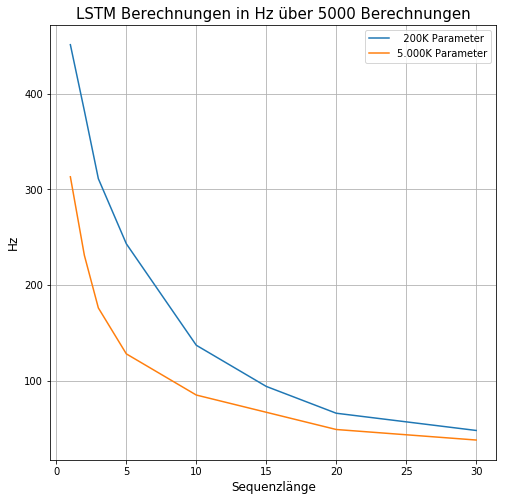

In [67]:
# lstm Berechnungszeiten über 5000 mit gtx 1060 6gb
# Trainable params: 272,801 Input 64X128X3

x       = [  1,   2,   3,   5,  10, 15, 20, 30]
y_200k  = [451, 382, 311, 243, 137, 94, 66, 48]
y_5000k = [313, 231, 176, 128,  85, 67, 49, 38]

fig = plt.figure(figsize=(8,8))
plt.title("LSTM Berechnungen in Hz über 5000 Berechnungen", fontsize=15)
plt.xlabel("Sequenzlänge", fontsize=12)
plt.ylabel("Hz", fontsize=12)
plt.grid()
plt.plot(x, y_200k)
plt.plot(x, y_5000k)
plt.legend(["  200K Parameter", "5.000K Parameter"])

# cnn Berechnungszeiten über 5000 mit gtx 1060 6gb ca. 521 Hz
# Trainable params: 243,937

In [6]:
import vis.utils.utils as kvu
import vis.visualization as kv

def _resolve_layer_idx(model, layer_name, layer_idx):
        idx = layer_idx
        if layer_name:
            idx = kvu.find_layer_idx(model, layer_name)

        return idx

def visualize_activation(model, layer_name=None, layer_idx=None, filter_indices=None, seed_input=None):
    idx = _resolve_layer_idx(model, layer_name=layer_name, layer_idx=layer_idx)

    return kv.visualize_activation(
        model=model,
        layer_idx=idx,
        filter_indices=filter_indices,
        seed_input=seed_input,
        backprop_modifier="guided")


In [40]:
from keras.models import load_model

# LOAD MODEL START
model = load_model(lstm_model_path)
model.summary()
# LOAD MODEL END

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv01 (TimeDistributed)     (None, None, 128, 128, 32 42368     
_________________________________________________________________
pool01 (TimeDistributed)     (None, None, 64, 64, 32)  0         
_________________________________________________________________
batch_norm01 (TimeDistribute (None, None, 64, 64, 32)  128       
_________________________________________________________________
conv02 (TimeDistributed)     (None, None, 64, 64, 64)  247872    
_________________________________________________________________
pool02 (TimeDistributed)     (None, None, 32, 32, 64)  0         
_________________________________________________________________
batch_norm02 (TimeDistribute (None, None, 32, 32, 64)  256       
_________________________________________________________________
conv03 (TimeDistributed)     (None, None, 32, 32, 96)  301152    
__________

In [23]:
lstm_layer = model.get_layer(name="lstm")
lstm_layer.return_sequences = False

model.layers[-2] = lstm_layer

print(model.layers[-2].return_sequences)

False


In [41]:
test_gen.batch_size = 1
test_gen.sequence_size = 5
test_gen.grayscale = False
test_gen.flip = False

x, y = test_gen[0]

print(x.shape)

# from keras.utils import CustomObjectScope
# with CustomObjectScope({'relu': relu}): 
    
fig=plt.figure(figsize=(15, 15))
# out = visualize_activation(model, layer_name="output", seed_input=x)
out = kv.visualize_cam(model, 1, filter_indices=1, seed_input=x, penultimate_layer_idx=0)
plt.imshow(out)
plt.show()

(1, 5, 128, 128, 3)


TypeError: 'NoneType' object cannot be interpreted as an integer

In [42]:
from keras.models import load_model

# LOAD MODEL START
model = load_model(cnn_model_path)
model.summary()
# LOAD MODEL END

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv01 (Conv2D)              (None, 64, 128, 32)       11648     
_________________________________________________________________
pool01 (MaxPooling2D)        (None, 32, 64, 32)        0         
_________________________________________________________________
batch_norm01 (BatchNormaliza (None, 32, 64, 32)        128       
_________________________________________________________________
relu01 (Activation)          (None, 32, 64, 32)        0         
_________________________________________________________________
conv02 (Conv2D)              (None, 32, 64, 64)        51264     
_________________________________________________________________
pool02 (MaxPooling2D)        (None, 16, 32, 64)        0         
_________________________________________________________________
batch_norm02 (BatchNormaliza (None, 16, 32, 64)        256       
__________

In [45]:
test_gen.batch_size = 1
test_gen.sequence_size = 0
test_gen.grayscale = False
test_gen.flip = False

x, y = test_gen[0]

print(x.shape)

(1, 64, 128, 3)


In [55]:
outs = []

for i in range(100):
    x, _ = test_gen[i+100]
    out = visualize_activation(model, layer_name="output", seed_input=x)
    outs.append(out)

In [57]:
for img in outs:
    cv2.imshow("window", img)
    key = cv2.waitKey(250)
    if key == 27:
        break
        
cv2.destroyAllWindows()